# the rental price of house on Seattle

If you were a citizen of Seattle, and just having a vacant house, how would you dispose your house to earn money? I thank rent your house is a good choice to earn money without any risk. But before loading the house information to AirBNB, you may need to make a survey. Which month is the peak tourist season? The impression of guests is positive or negative? What's the distribution of neighbourhood' rental price? Can I predict the price of my house using machine learning?

Fortunately, all these questions can solved using dataset published by AirBNB company. Let's do it!!

### Data Gather

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import re
%matplotlib inline

In [2]:
# load the datasets
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

In [43]:
#check the numbers of columns and rows of the dataset
print calendar.shape
print listings.shape
print reviews.shape

(1393570, 4)
(3818, 92)
(84849, 6)


In [9]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 53.2+ MB


## Question 1: which month is the peak tourist month?

### Data access and clean

In [3]:
#split the date of calendar, and  map season to the month
split_month = lambda col: col.split('-')[1] #extract month from date
split_day = lambda col: col.split('-')[2] #extract day from date
calendar['month'] = calendar['date'].apply(split_month) 
calendar['day'] = calendar['date'].apply(split_day)
season = {'01':'spring', '02':'spring', '03':'spring',
          '04':'summer', '05':'summer', '06':'summer',
          '07':'autumn', '08':'autumn', '09':'autumn', 
          '10':'winter', '11':'winter', '12':'winter'}
calendar['season'] = calendar.month.map(season)
calendar.head()

,listing_id,date,available,price,month,day,season
0,241032,2016-01-04,t,$85.00,01,04,spring
1,241032,2016-01-05,t,$85.00,01,05,spring
2,241032,2016-01-06,f,NaN,01,06,spring
3,241032,2016-01-07,f,NaN,01,07,spring
4,241032,2016-01-08,f,NaN,01,08,spring


In [4]:
#remove the $ sign
calendar['price'] = calendar['price'].str.replace('$', '')
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].astype(float)
#drop the rows with missing values in price 
new_calendar = calendar.dropna(subset = ['price'], how = 'any')
new_calendar.head()

,listing_id,date,available,price,month,day,season
0,241032,2016-01-04,t,85,01,04,spring
1,241032,2016-01-05,t,85,01,05,spring
9,241032,2016-01-13,t,85,01,13,spring
10,241032,2016-01-14,t,85,01,14,spring
14,241032,2016-01-18,t,85,01,18,spring


### Data analyze and visualize

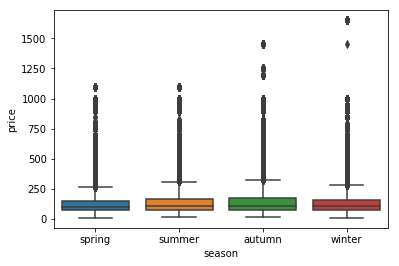

In [25]:
#plot the distribution of price with the season using boxplot

sns.boxplot(x = 'season', y = 'price', data = new_calendar)

#### from the boxplot, the price have no significant difference very with season

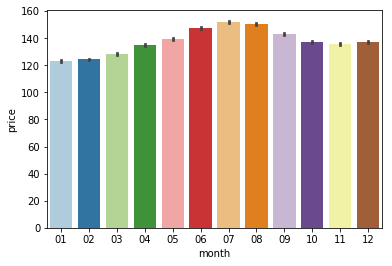

In [37]:
#plot barplot 
sns.barplot(x = 'month', y = 'price', data = new_calendar, palette = 'Paired')
plt.savefig('month_price.png')

#### As we can see, June, July and August is the top three on price, we can infer that July is the peak tourist month. From the Wikipedia, we know autumn, winter and early spring are characterized by rain in Seattle and a lot of events and festivals in summer, so this result is reasonable.

## Question 2:The comments about accommodation made by guests are positive or negative?

### Data assess

In [32]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [43]:
#concatenating the comments into a string
text = reviews['comments'].str.cat(sep = ',', na_rep = '')
len(text)

32831422

### Data clean and visualize

In [50]:
from wordcloud import WordCloud
from PIL import Image

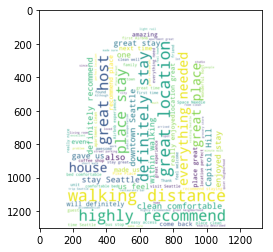

In [52]:
#using a house image to generate wordcloud of comments
home_mask = np.array(Image.open('house-cartoon.jpg')) # load the house image
wordcloud = WordCloud(background_color = 'white', max_words = 100,
                      mask = home_mask).generate(text)
#using 100 high frequency words to show guest's feeling on accommodation
wordcloud.to_file('comments.jpg')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

#### It's surprising, a lot of people have a good impression on accommodation, they think the houses they lived are great places to highly recommend.

## Question 3: What is the distribution of neighbourhood's rental prices?

### Data assess and clean

In [5]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [6]:
#drop the columns without information about the price
new_listings = listings.iloc[:, 34:-34]
useless_columns = ['street', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'smart_location', 
                   'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'amenities', 'market']
new_listings = new_listings.drop(useless_columns, axis = 1)
new_listings['listing_id'] = listings['id']
new_listings.head()

,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,listing_id
0,Queen Anne,Apartment,Entire home/apt,4,1.0,1,1,Real Bed,NaN,$85.00,241032
1,Queen Anne,Apartment,Entire home/apt,4,1.0,1,1,Real Bed,NaN,$150.00,953595
2,Queen Anne,House,Entire home/apt,11,4.5,5,7,Real Bed,NaN,$975.00,3308979
3,Queen Anne,Apartment,Entire home/apt,3,1.0,0,2,Real Bed,NaN,$100.00,7421966
4,Queen Anne,House,Entire home/apt,6,2.0,3,3,Real Bed,NaN,$450.00,278830


In [7]:
#calculate the mean price of rental housing
new_listings['price'] = new_listings['price'].str.replace('$', '')
new_listings['price'] = new_listings['price'].str.replace(',', '')
new_listings['price'] = new_listings['price'].astype(float)
new_listings['price'].mean()

127.97616553169199

In [8]:
#merge new_listings and calendar using listing_id
df = pd.merge(new_listings, calendar, on = 'listing_id')
df.shape

(1393570, 17)

In [7]:
df.head()

,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price_x,listing_id,date,available,price_y,month,day,season
0,Queen Anne,Apartment,Entire home/apt,4,1,1,1,Real Bed,NaN,$85.00,241032,2016-01-04,t,85,01,04,spring
1,Queen Anne,Apartment,Entire home/apt,4,1,1,1,Real Bed,NaN,$85.00,241032,2016-01-05,t,85,01,05,spring
2,Queen Anne,Apartment,Entire home/apt,4,1,1,1,Real Bed,NaN,$85.00,241032,2016-01-06,f,NaN,01,06,spring
3,Queen Anne,Apartment,Entire home/apt,4,1,1,1,Real Bed,NaN,$85.00,241032,2016-01-07,f,NaN,01,07,spring
4,Queen Anne,Apartment,Entire home/apt,4,1,1,1,Real Bed,NaN,$85.00,241032,2016-01-08,f,NaN,01,08,spring


### Data analyze

In [16]:
null_feet = df['square_feet'].notnull().sum()
print 'the number of null missing values in column square_feet', null_feet

the number of null missing values in column square_feet 35405


In [8]:
# square_feet missing a lot of data, so drop it
df = df.drop(['square_feet', 'price_x', 'listing_id', 'date'], axis = 1)
df.rename(columns = {'price_y':'price'}, inplace = True)
df.head()

,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,available,price,month,day,season
0,Queen Anne,Apartment,Entire home/apt,4,1,1,1,Real Bed,t,85,01,04,spring
1,Queen Anne,Apartment,Entire home/apt,4,1,1,1,Real Bed,t,85,01,05,spring
2,Queen Anne,Apartment,Entire home/apt,4,1,1,1,Real Bed,f,NaN,01,06,spring
3,Queen Anne,Apartment,Entire home/apt,4,1,1,1,Real Bed,f,NaN,01,07,spring
4,Queen Anne,Apartment,Entire home/apt,4,1,1,1,Real Bed,f,NaN,01,08,spring


In [9]:
# drop the rrows having missing values in price column
df = df.dropna(subset = ['price'], how = 'any')

In [10]:
df.shape

(934542, 13)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 13 columns):
neighbourhood    827611 non-null object
property_type    934233 non-null object
room_type        934542 non-null object
accommodates     934542 non-null int64
bathrooms        929739 non-null float64
bedrooms         932539 non-null float64
beds             934177 non-null float64
bed_type         934542 non-null object
available        934542 non-null object
price            934542 non-null float64
month            934542 non-null object
day              934542 non-null object
season           934542 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 99.8+ MB


In [57]:
# count the missing values of columns
df.isnull().sum()

neighbourhood    106931
property_type       309
room_type             0
accommodates          0
bathrooms          4803
bedrooms           2003
beds                365
bed_type              0
available             0
price                 0
month                 0
day                   0
season                0
dtype: int64

In [34]:
df['neighbourhood'].value_counts().count()

81

### Data visualize

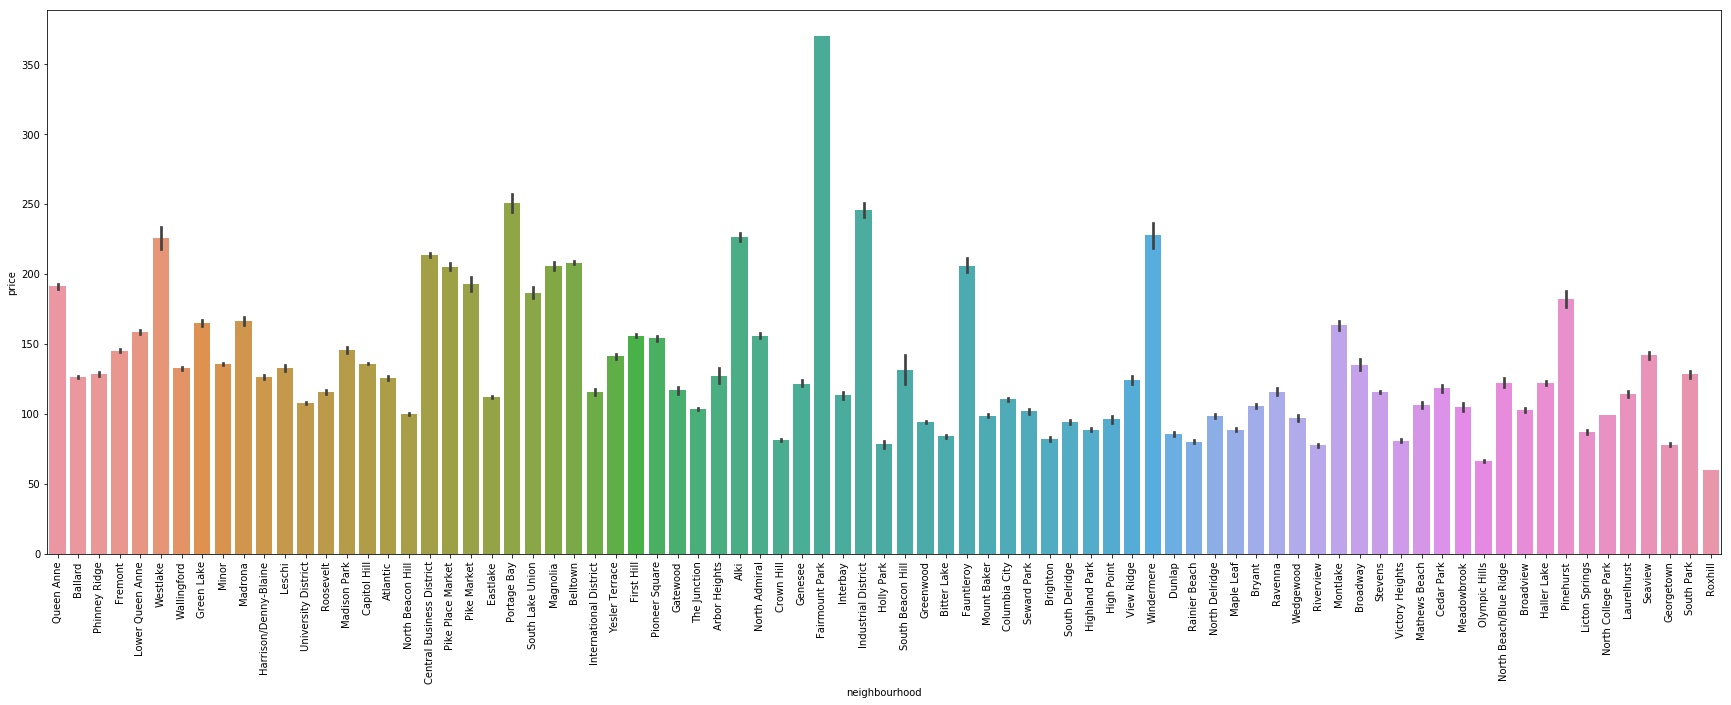

In [31]:
fig, ax = plt.subplots(figsize = (30, 10))
grid = sns.barplot(x = 'neighbourhood', y = 'price', data = df)
grid.set_xticklabels(grid.get_xticklabels(), rotation = 90)
plt.savefig('price_neighbourhood.png')

In [32]:
df[df['neighbourhood'] == 'Fairmount Park']

,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,available,price,month,day,season
679995,Fairmount Park,House,Entire home/apt,8,2.5,5,1,Real Bed,t,370,01,04,spring
679996,Fairmount Park,House,Entire home/apt,8,2.5,5,1,Real Bed,t,370,01,05,spring
679997,Fairmount Park,House,Entire home/apt,8,2.5,5,1,Real Bed,t,370,01,06,spring
679998,Fairmount Park,House,Entire home/apt,8,2.5,5,1,Real Bed,t,370,01,07,spring
679999,Fairmount Park,House,Entire home/apt,8,2.5,5,1,Real Bed,t,370,01,08,spring
680000,Fairmount Park,House,Entire home/apt,8,2.5,5,1,Real Bed,t,370,01,09,spring
680001,Fairmount Park,House,Entire home/apt,8,2.5,5,1,Real Bed,t,370,01,10,spring
680002,Fairmount Park,House,Entire home/apt,8,2.5,5,1,Real Bed,t,370,01,11,spring
680003,Fairmount Park,House,Entire home/apt,8,2.5,5,1,Real Bed,t,370,01,12,spring
680004,Fairmount Park,House,Entire home/apt,8,2.5,5,1,Real Bed,t,370,01,13,spring


#### the figure shows fairmount park has the highest price, but when we look at the dataset, there are only one house in this neighbourhood, so I think this price is not typically of the fairmount park. the data shows Portage Bay and Industrial District.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0024f8890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb0003ae990>]], dtype=object)

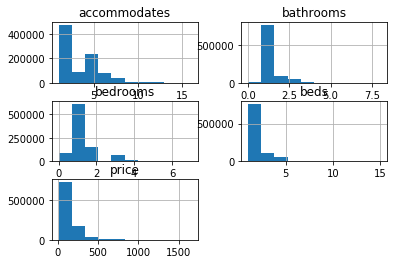

In [58]:
df.hist()

In [63]:
#fill missing values with the mode in non-categorical variables
'''
the histograms show that bathrooms, beds and bedrooms are not normal distributions, there are all skewed distributions, 
and the common feature in these ground is that one value occupied the large proportion,
so filling na with mean is inapproprite. The mode of a set of data values is the value that appears most often, 
it is the value that is most likely to be sampled. So using mode fill na is a good chioce
'''

df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
df['beds'] = df['beds'].fillna(df['beds'].mode()[0])

#creat dummy variables for categorical variables, and drop the original column ,
'''
from the dataset, there are 934542 records, and the missing values in neighbourhood have 106931 records, about 11%, 
so the NaN in column neighbourhood can't remove, the missing values as a new columns in the dataset.
'''

def creat_dummy(df, cat_cols):
    '''
    Input : 
    df  - dataframe
    cat_cols  - a list containing categorical variables of df
    Output:
    df  - dataframe
    
    This function create dummy variables and drop the original categorical variables
    '''
    for col in cat_cols: #for each categorical variables add dummy variable, drop original column and reserve NaN
        try:
            df = pd.concat([df.drop(col, axis = 1), pd.get_dummies(df[col], dummy_na = True)], axis = 1)
        except:
            continue
    return df
cat_df = df.select_dtypes(include = ['object']) #select categorical variables
cat_cols = cat_df.columns
new_dummy_df = creat_dummy(df, cat_cols)
new_dummy_df.shape

(934542, 119)

## Predict the rental price using linear regression model

### Data model

In [4]:
new_dummy_df = new_dummy_df.drop('season', axis = 1)
feature = new_dummy_df.drop('price', axis = 1)
target = new_dummy_df['price']
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.3, random_state = 1)

#instantiate and fit the model
lm = LinearRegression(normalize = True)
lm.fit(X_train, y_train)

#predict 
test_pred = lm.predict(X_test)
train_pred = lm.predict(X_train)

#score the results
test_score = r2_score(y_test, test_pred)
train_score = r2_score(y_train, train_pred)

print test_score
print train_score

0.615050418715
0.61848919045


##### the r2_score on the training dataset is 0.618, and r2_score on the test dataset is 0.615, the model is not overfiting. Frankly speaking, this model still have room for improvement, maybe we can add some variables to increase information about rental price or change the machine learning algorithm.